# Implementação de seq2seq para aprendizado da operação resto

Nessa implementação teremos o uso de redes neurais com memória onde:
- Entrada: "535%61"
- Saída esperada: "47"

O padding é realizado utilizando espaços.


Esse código é baseado em: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py


In [1]:
# Imports
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


In [0]:
# Parâmetros do modelo e do conjunto de dados. Altere esses valores!
TRAINING_SIZE = 100000
DIGITS = 3

# REVERSE indica se a ordem dos operandos deve ser trocada
REVERSE = True

# O tamanho máximo da entrada é 'int % int' (e.g., '345%678').
# Cada 'int' possui DIGITS como tamanho. Normalmente você não vai precisar alterar esse valor.
MAXLEN = DIGITS + 1 + DIGITS

# Caracteres utilizados. Normalmente você não vai precisar alterar esse valor.
chars = '0123456789% '


In [0]:
# Configuração da rede neural.
# Você pode editar o tipo dela (layers.RNN ou layers.GRU), assim como o número interno de camadas e células.
# Você também pode alterar o número de questões em cada batch de treinamento.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 64
LAYERS = 1

# Você pode alterar o número de épocas de treinamento, além do nome do arquivo e a configuração de EarlyStopping.
EPOCHS = 100
FILEPATH = "s2s-mod-{epoch:02d}-{val_acc:.2f}.hdf5"
PATIENCE = 5

In [0]:
# Classe para criar tabela de caracteres
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [5]:
ctable = CharacterTable(chars)
questions = []
expected = []
seen = set()

# Os dados são gerados, onde chamamos os operandos (a%b) de 'questão' e o resultado da operação de 'resposta'.
#   Repare que quando o resultado da operação resto é igual a um dos operandos, esse conjunto de dados é descartado.
print('Generating data...')
while len(questions) < TRAINING_SIZE:
  
    # Gera números aleatórios.
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    
    # Verifica se esses valores já existem no conjunto de dados.
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)

    # Realiza o padding
    q = '{}%{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    
    # Calcula a resposta.
    try:
      ans = a % b
    except:
      ans = 0

    # Verifica se a resposta é igual a algum dos operandos.
    if (ans == a) or (ans == b):
      continue
    
    # Evita questões com respostas muito pequenas
    ans_str = str(ans)
    if len(ans_str) < 2:
      continue

    # Realiza o padding da resposta de modo que ela sempre tenha o mesmo tamanho (DIGITS + 1)
    ans_str += ' ' * (DIGITS + 1 - len(ans_str))
    
    if REVERSE:
        # Inverte a questão (ex. '12%345  ' -> '  543%21'. Repare no espaço utilizado.).
        query = query[::-1]
        
    # Salva a questão no conjunto de dados
    questions.append(query)
    expected.append(ans_str)

print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000


In [6]:
print('Vetorização...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vetorização...


In [0]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [0]:
# Separa como conjunto de validação 10% dos dados gerados
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

In [9]:
print('Dados de treinamento:')
print(x_train.shape)
print(y_train.shape)


Dados de treinamento:
(90000, 7, 12)
(90000, 4, 12)


In [10]:
print('Dados de validação:')
print(x_val.shape)
print(y_val.shape)

Dados de validação:
(10000, 7, 12)
(10000, 4, 12)


In [13]:
print('Contruindo modelo...')
model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))

# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):

  # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Contruindo modelo...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


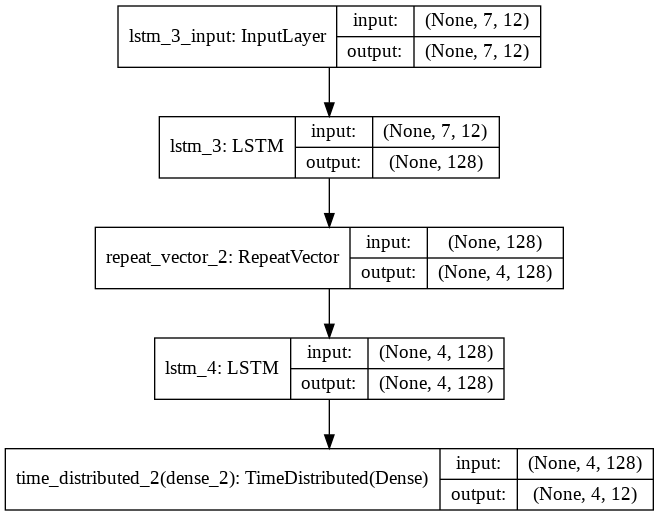

In [14]:
# Imprime o desenho do modelo utilizado na rede neural.
from keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=True, to_file='model.png')

In [0]:
print('Treinando modelo...')

# Train the model each generation and show predictions against the validation
# dataset.

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)

# Configuração do nome do arquivo para checkpoints
checkpoint = ModelCheckpoint(FILEPATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Treinamento de fato.
history = model.fit(
            x_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            callbacks=[early_stop,checkpoint]
)

Treinando modelo...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 90000 samples, validate on 10000 samples
Epoch 1/100





90000/90000 [==============================] - 51s 571us/step - loss: 1.4078 - acc: 0.5078 - val_loss: 1.3685 - val_acc: 0.5148

Epoch 00001: val_acc improved from -inf to 0.51482, saving model to s2s-mod-01-0.51.hdf5
Epoch 2/100
24960/90000 [=======>......................] - ETA: 32s - loss: 1.3519 - acc: 0.5184

In [0]:
print("Imprimindo 100 exemplos aleatórios de acertos/erros da rede neural...")

for i in range(100):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    
    if correct == guess:
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        print(colors.ok + '☑' + colors.close, end=' ')
        print(guess)
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    

In [0]:
# Gera os gráficos com o desempenho da rede relaticos a acurácia e perda, respectivamente.

import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()